In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @markdown

df_coordenadas = pd.read_csv('/content/drive/MyDrive/data/Regressive/Dados_Regressao.csv')


df_coordenadas['Valor'] = df_coordenadas['Valor'].round(2)
df_coordenadas.drop(columns=['Mês','Data'], inplace=True)
df_coordenadas.set_index(['Instituição', 'Conta', 'Ano'], inplace=True)
df_coordenadas = df_coordenadas.groupby(['Instituição', 'Conta', 'Ano'])['Valor'].sum()
df_coordenadas = df_coordenadas.reset_index()
df_coordenadas['Valor_Pct_Change'] = df_coordenadas.groupby(['Instituição', 'Conta'])['Valor'].pct_change()
df_coordenadas.dropna(subset=['Valor_Pct_Change'], inplace=True)


df_coordenadas = df_coordenadas.pivot_table(index='Instituição',
                                            columns=['Conta', 'Ano'],
                                            values='Valor_Pct_Change',
                                            aggfunc='sum').reset_index()
df_coordenadas.columns = ['Instituição'] + [f'{conta}_{ano}' for conta, ano in df_coordenadas.columns[1:]]

municipios = ['Balneário Camboriú', 'Estância', 'Guarujá', 'Jijoca de Jericoacoara', 'Tibau do Sul']

df_coordenadas_new_cities = df_coordenadas[df_coordenadas['Instituição'].isin(municipios)]
df_coordenadas = df_coordenadas[~df_coordenadas['Instituição'].isin(municipios)]

df_coordenadas_ = df_coordenadas.copy()

## AGNES

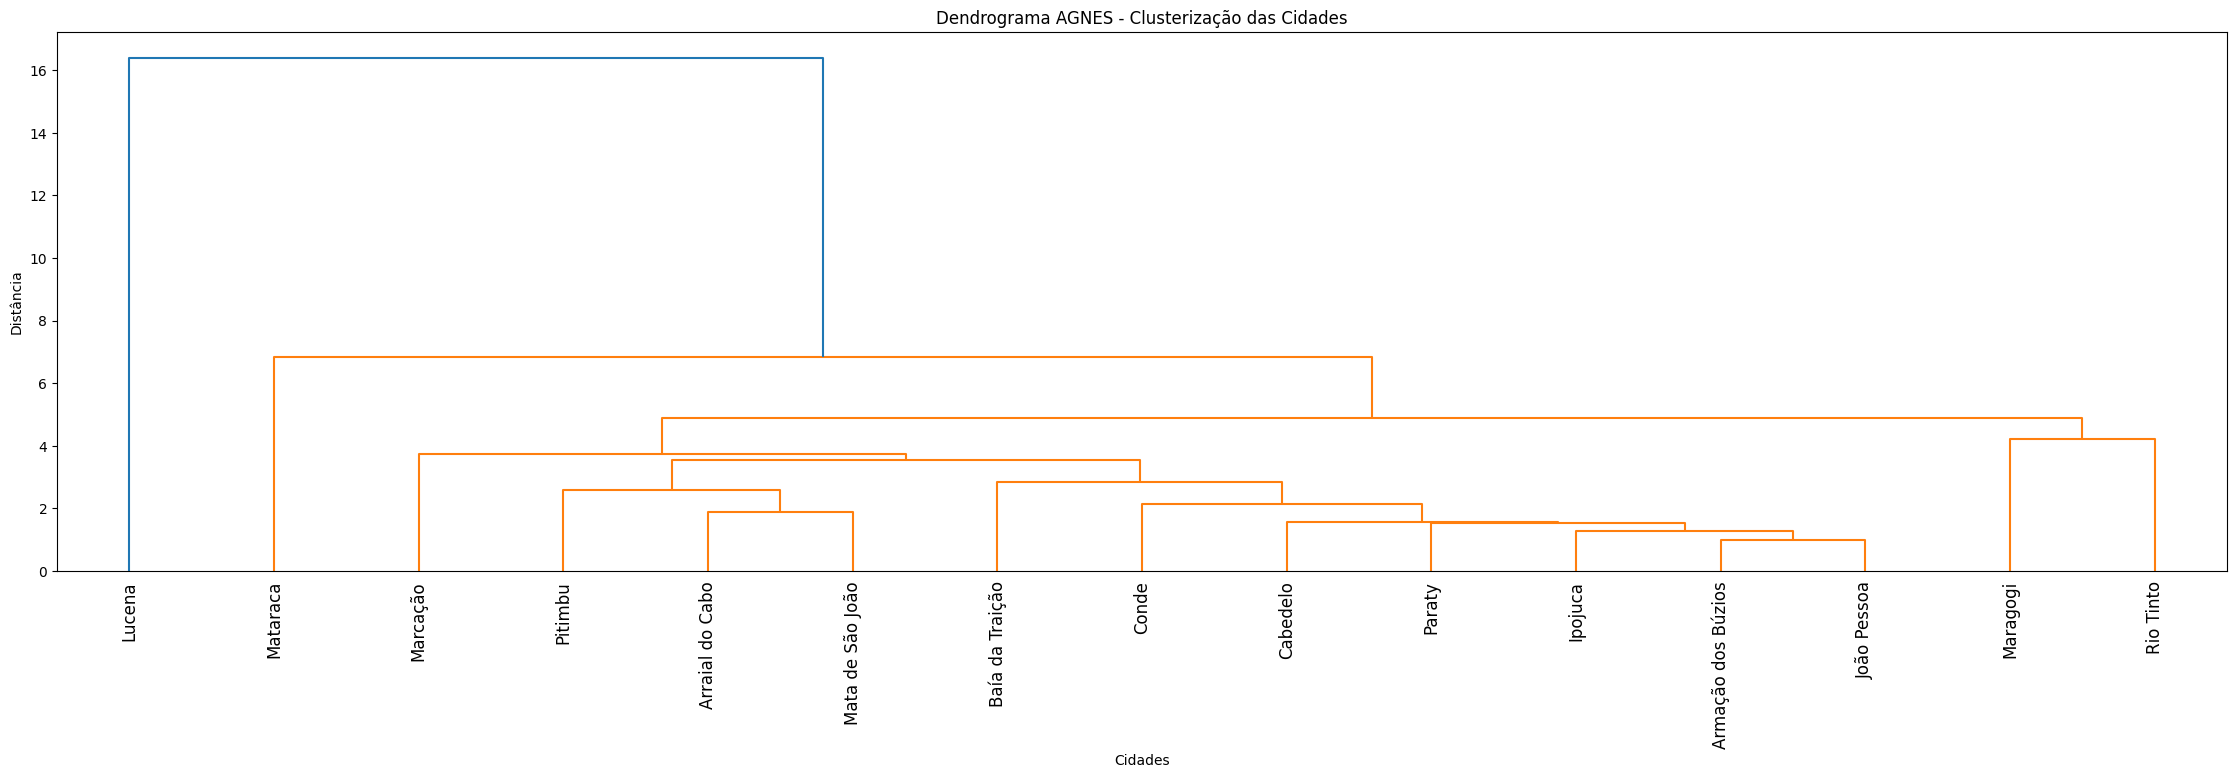

           Instituição  Cluster
12            Maragogi        0
18           Rio Tinto        0
0   Armação dos Búzios        1
1      Arraial do Cabo        1
3      Baía da Traição        1
4             Cabedelo        1
5                Conde        1
8              Ipojuca        1
10         João Pessoa        1
13            Marcação        1
14    Mata de São João        1
16              Paraty        1
17             Pitimbu        1
15            Mataraca        2
11              Lucena        3


In [ ]:
# @markdown

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage


df_agnes = df_coordenadas.copy()
X = df_agnes.drop(columns='Instituição').values

agnes = AgglomerativeClustering(n_clusters=4, linkage='ward')

clusters = agnes.fit_predict(X)

df_agnes['Cluster'] = clusters
df_coordenadas_['Cluster_AGNES'] = clusters

Z = linkage(X, method='ward')

# Plotting the dendrogram
plt.figure(figsize=(28, 7))
plt.title('Dendrograma AGNES - Clusterização das Cidades')
dendrogram(Z, labels=df_agnes['Instituição'].values, leaf_rotation=90, leaf_font_size=12)
plt.xlabel('Cidades')
plt.ylabel('Distância')
plt.show()

print(df_agnes[['Instituição', 'Cluster']].sort_values(by='Cluster'))

## DIANA

In [ ]:
# @markdown{display-mode: "form"}

df_diana = df_coordenadas.copy()
X = np.round(df_diana.values[:,1:28].astype(float), 5)

def calc_dists_matrix(X):
  dists = []
  for i in range(X.shape[0]):
    dists.append([np.linalg.norm(X[i]-X[j]) for j in range(X.shape[0])])

  return np.array(dists).round(5)


"""
Created on Thu Mar 29 21:02:59 2018

@author: Divyang Vashi
"""

num_clusters = 4

all_elements = df_diana['Instituição'].values.tolist()
dissimilarity_matrix = pd.DataFrame(calc_dists_matrix(X), index=all_elements, columns=all_elements)

def avg_dissim_within_group_element(ele, element_list):
    max_diameter = -np.inf
    sum_dissm = 0
    for i in element_list:
        sum_dissm += dissimilarity_matrix[ele][i]
        if( dissimilarity_matrix[ele][i]  > max_diameter):
            max_diameter = dissimilarity_matrix[ele][i]
    if(len(element_list)>1):
        avg = sum_dissm/(len(element_list)-1)
    else:
        avg = 0
    return avg

def avg_dissim_across_group_element(ele, main_list, splinter_list):
    if len(splinter_list) == 0:
        return 0
    sum_dissm = 0
    for j in splinter_list:
        sum_dissm = sum_dissm + dissimilarity_matrix[ele][j]
    avg = sum_dissm/(len(splinter_list))
    return avg


def splinter(main_list, splinter_group):
    most_dissm_object_value = -np.inf
    most_dissm_object_index = None
    for ele in main_list:
        x = avg_dissim_within_group_element(ele, main_list)
        y = avg_dissim_across_group_element(ele, main_list, splinter_group)
        diff= x -y
        if diff > most_dissm_object_value:
            most_dissm_object_value = diff
            most_dissm_object_index = ele
    if(most_dissm_object_value>0):
        return  (most_dissm_object_index, 1)
    else:
        return (-1, -1)

def split(element_list):
    main_list = element_list
    splinter_group = []
    (most_dissm_object_index,flag) = splinter(main_list, splinter_group)
    while(flag > 0):
        main_list.remove(most_dissm_object_index)
        splinter_group.append(most_dissm_object_index)
        (most_dissm_object_index,flag) = splinter(element_list, splinter_group)

    return (main_list, splinter_group)

def max_diameter(cluster_list):
    max_diameter_cluster_index = None
    max_diameter_cluster_value = -np.inf
    index = 0
    for element_list in cluster_list:
        for i in element_list:
            for j in element_list:
                if dissimilarity_matrix[i][j]  > max_diameter_cluster_value:
                    max_diameter_cluster_value = dissimilarity_matrix[i][j]
                    max_diameter_cluster_index = index

        index +=1

    if(max_diameter_cluster_value <= 0):
        return -1

    return max_diameter_cluster_index


current_clusters = ([all_elements])
level = 1
index = 0
while(level < num_clusters):
    #print(level, current_clusters)
    (a_clstr, b_clstr) = split(current_clusters[index])
    del current_clusters[index]
    current_clusters.append(a_clstr)
    current_clusters.append(b_clstr)
    index = max_diameter(current_clusters)
    level +=1


print(level, current_clusters)

labels = {}
for cluster in range(len(current_clusters)):
  for cidade in current_clusters[cluster]:
    labels[cidade] = cluster

df_coordenadas_['Cluster_DIANA'] = df_coordenadas_['Instituição'].map(labels)

4 [['Lucena'], ['Mataraca'], ['Armação dos Búzios', 'Arraial do Cabo', 'Baía da Traição', 'Cabedelo', 'Conde', 'Ipojuca', 'João Pessoa', 'Marcação', 'Mata de São João', 'Paraty', 'Pitimbu', 'Rio Tinto'], ['Maragogi']]


## KMEANS + PCA

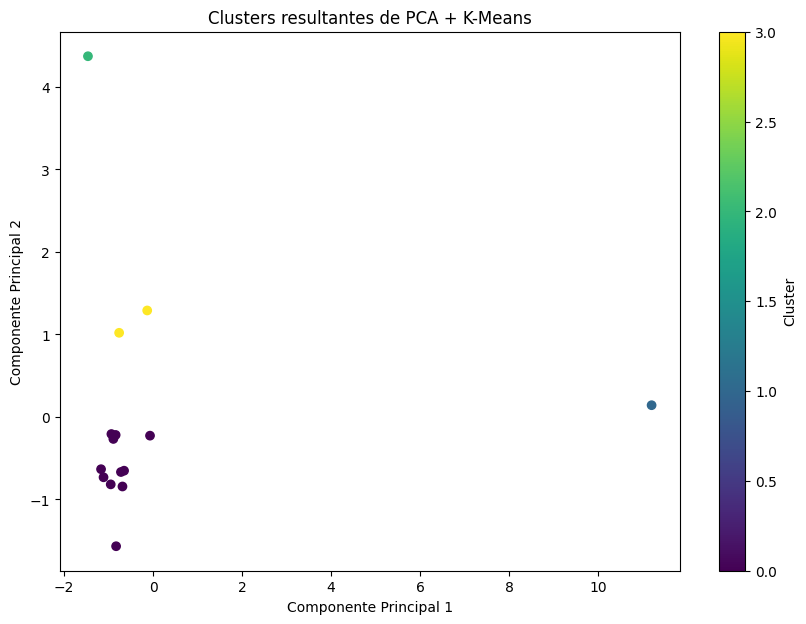

           Instituição  Cluster_AGNES  Cluster_KMeans
12            Maragogi              0               3
18           Rio Tinto              0               3
0   Armação dos Búzios              1               0
1      Arraial do Cabo              1               0
3      Baía da Traição              1               0
4             Cabedelo              1               0
5                Conde              1               0
8              Ipojuca              1               0
10         João Pessoa              1               0
13            Marcação              1               0
14    Mata de São João              1               0
16              Paraty              1               0
17             Pitimbu              1               0
15            Mataraca              2               2
11              Lucena              3               1
Adjusted Rand Index between AGNES and K-Means clusters: 1.0


In [ ]:
# @markdown
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Assuming df_coordenadas is your data from AGNES with 'Instituição' and 'Cluster'
# Dropping the 'Instituição' and 'Cluster' columns to only use the coordinates (45 values per city)
X_ = df_coordenadas.drop(columns=['Instituição']).values

# Step 1: Applying PCA to reduce dimensions to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_)

# Step 2: Apply K-Means clustering on the reduced data (2D)
n_clusters = 4  # We will use 4 clusters as in AGNES
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_clusters = kmeans.fit_predict(X_pca)

# Adding the K-Means clusters to the original dataframe
df_coordenadas_['Cluster_KMeans'] = kmeans_clusters

# Step 3: Visualizing the clusters from PCA + K-Means
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_clusters, cmap='viridis')
plt.title('Clusters resultantes de PCA + K-Means')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

# Step 4: Comparing the K-Means clusters with AGNES clusters
comparison_df = df_coordenadas_[['Instituição', 'Cluster_AGNES', 'Cluster_KMeans']]
print(comparison_df.sort_values(by='Cluster_AGNES'))

# Step 5: Optionally calculate a metric to compare the cluster assignments
from sklearn.metrics import adjusted_rand_score

# Adjusted Rand Index to measure similarity between AGNES and K-Means clusterings
ari = adjusted_rand_score(df_coordenadas_['Cluster_AGNES'], df_coordenadas_['Cluster_KMeans'])
print(f'Adjusted Rand Index between AGNES and K-Means clusters: {ari}')

## Associação de Novas Cidades aos Grupos

In [ ]:
# @markdown

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Prepare the data for LDA
X_train = df_coordenadas_.drop(columns=['Instituição', 'Cluster_AGNES', 'Cluster_KMeans','Cluster_DIANA'])
y_train = df_coordenadas_['Cluster_AGNES']

# Create and train the LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Prepare the new cities' data for prediction
X_new = df_coordenadas_new_cities.drop(columns=['Instituição'])
# Predict the clusters for new cities
predicted_clusters = lda.predict(X_new)

# Assign the predicted clusters to the df5 dataframe
df_coordenadas_new_cities['Cluster_AGNES'] = predicted_clusters

# Print the results
print(df_coordenadas_new_cities[['Instituição', 'Cluster_AGNES']])


# Prepare the data for LDA
X_train = df_coordenadas_.drop(columns=['Instituição', 'Cluster_AGNES', 'Cluster_KMeans','Cluster_DIANA'])
y_train = df_coordenadas_['Cluster_KMeans']

# Create and train the LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Prepare the new cities' data for prediction
X_new = df_coordenadas_new_cities.drop(columns=['Instituição','Cluster_AGNES'])
# Predict the clusters for new cities
predicted_clusters = lda.predict(X_new)

# Assign the predicted clusters to the df5 dataframe
df_coordenadas_new_cities['Cluster_KMeans'] = predicted_clusters

# Print the results
print(df_coordenadas_new_cities[['Instituição', 'Cluster_KMeans']])


# Prepare the data for LDA
X_train = df_coordenadas_.drop(columns=['Instituição', 'Cluster_AGNES', 'Cluster_KMeans','Cluster_DIANA'])
y_train = df_coordenadas_['Cluster_DIANA']

# Create and train the LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Prepare the new cities' data for prediction
X_new = df_coordenadas_new_cities.drop(columns=['Instituição','Cluster_AGNES','Cluster_KMeans'])
# Predict the clusters for new cities
predicted_clusters = lda.predict(X_new)

# Assign the predicted clusters to the df5 dataframe
df_coordenadas_new_cities['Cluster_DIANA'] = predicted_clusters

# Print the results
print(df_coordenadas_new_cities[['Instituição', 'Cluster_DIANA']])

               Instituição  Cluster_AGNES
2       Balneário Camboriú              1
6                 Estância              1
7                  Guarujá              1
9   Jijoca de Jericoacoara              1
19            Tibau do Sul              1
               Instituição  Cluster_KMeans
2       Balneário Camboriú               0
6                 Estância               0
7                  Guarujá               0
9   Jijoca de Jericoacoara               0
19            Tibau do Sul               0
               Instituição  Cluster_DIANA
2       Balneário Camboriú              2
6                 Estância              2
7                  Guarujá              2
9   Jijoca de Jericoacoara              3
19            Tibau do Sul              2


## Visualização

In [ ]:
df_coordenadas_.reset_index(inplace=True, drop=True)
df_coordenadas_new_cities.reset_index(inplace=True, drop=True)

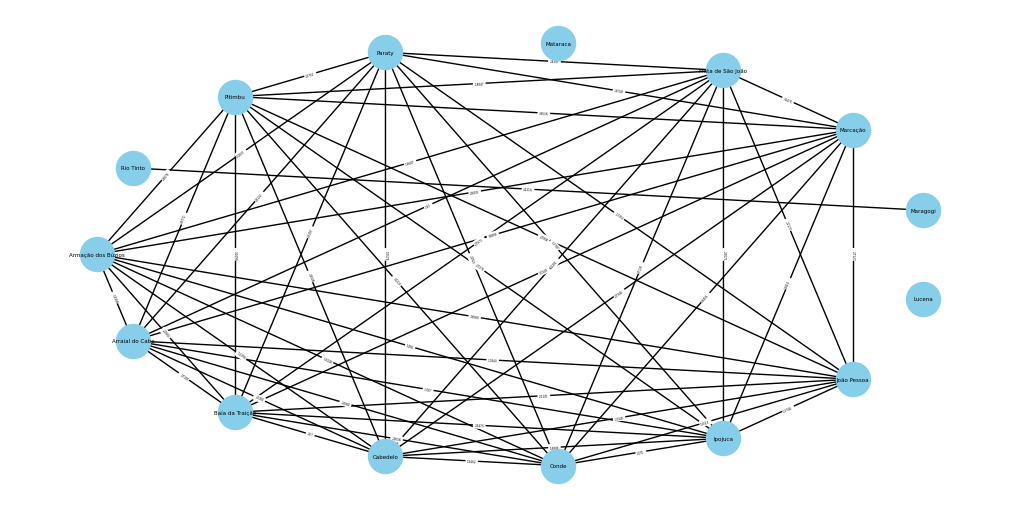

In [ ]:
# @markdown

from scipy.spatial.distance import cdist
import networkx as nx

G = nx.Graph()

# Adiciona nós ao grafo com base nas cidades
for index, row in df_coordenadas_.iterrows():
    G.add_node(row['Instituição'], label=row['Cluster_AGNES'])

for grupo in df_coordenadas_['Cluster_AGNES'].unique():
  df_temp = df_coordenadas_[df_coordenadas_['Cluster_AGNES'] == grupo].copy()
  df_temp.reset_index(inplace=True, drop=True)
  df_dists = df_temp.drop(columns=['Instituição','Cluster_AGNES', 'Cluster_KMeans','Cluster_DIANA']).copy()
  distancias = cdist(df_dists, df_dists, 'euclidean')

  for i in range(df_temp.shape[0]):
    for j in range(i + 1, df_temp.shape[0]):
      G.add_edge(df_temp['Instituição'][i], df_temp['Instituição'][j], weight=np.round(distancias[i][j],4))

plt.figure(figsize=(10, 5))
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_size=600, node_color='skyblue', font_size=4)

# Adiciona rótulos de aresta com as distâncias
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=2)

# Exibe o grafo
plt.show()

In [ ]:
# @markdown
df_agregado = pd.concat([df_coordenadas_, df_coordenadas_new_cities])

G = nx.Graph()

# Adiciona nós ao grafo com base nas cidades
for index, row in df_agregado.iterrows():
    G.add_node(row['Instituição'], label=row['Cluster_AGNES'])

for grupo in df_agregado['Cluster_AGNES'].unique():
  df_temp = df_agregado[df_agregado['Cluster_AGNES'] == grupo].copy()
  df_temp.reset_index(inplace=True, drop=True)
  df_dists = df_temp.drop(columns=['Instituição','Cluster_AGNES', 'Cluster_KMeans','Cluster_DIANA']).copy()
  distancias = cdist(df_dists, df_dists, 'euclidean')

  for i in range(df_temp.shape[0]):
    for j in range(i + 1, df_temp.shape[0]):
      G.add_edge(df_temp['Instituição'][i], df_temp['Instituição'][j], weight=np.round(distancias[i][j],4))

plt.figure(figsize=(10, 5))
pos = nx.spring_layout(G, k=0.99, iterations=200)
nx.draw(G, pos, with_labels=True, node_size=600, node_color='skyblue', font_size=4)

# Adiciona rótulos de aresta com as distâncias
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=2)

# Exibe o grafo
plt.show()